In [2]:
import sys
# in order that the parent directory can be accessed, as this notebook
# is in the 'notebooks/' subdirectory
sys.path[1:1] = ['..']
%load_ext autoreload
%autoreload 2

In [6]:
from bayesianAB.event_stream import ABtest
from bayesianAB.metrics import many_iterations
from bayesianAB.risk import risk

In [12]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## No true difference

If there is zero difference between the two means, then both the _expected loss_ and the _expected gain_ will tend towards zero. This is shown in the next plot.

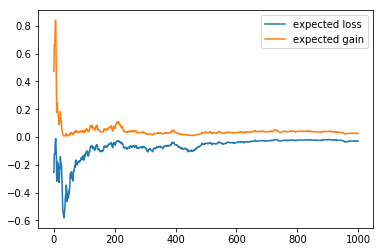

In [35]:
# run an AB test for a while and plot the expected loss
ab = ABtest.from_simple_args(true_diff=0, sd=1, weight=0.3)
losses_and_gains = many_iterations(ab, 1000)

plt.plot(losses_and_gains.expected_loss, label='expected loss');
plt.plot(losses_and_gains.expected_gain, label='expected gain');
plt.legend();


To emphasize the point, we simulate 100 experiments and show how all the loss traces tend towards zero

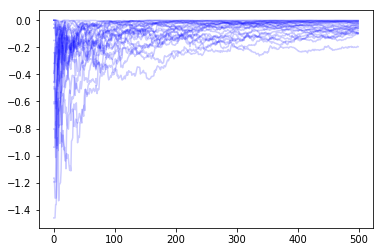

In [45]:
# run an AB test for a while and plot the expected loss
for seed in range(25):
    ab = ABtest.from_simple_args(true_diff=0, sd=1, weight=0.3, seed=seed)
    losses_and_gains = many_iterations(ab, 500)
    plt.plot(losses_and_gains.expected_loss, color='blue', alpha=0.2);